In [1]:
# add src to path
import importlib

import sys, os; sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.features import add_basic_features, add_interactions, add_ratios
from src.build_matrix import build_design_matrices
from src.io_utils import save_parquet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from joblib import parallel_backend
from src.config import CAP_COLS, SCALE_FEATURES, LOG_COLS
from src.encoders import build_preprocessor
from sklearn.preprocessing import StandardScaler



# 0) Load raw
Ames = pd.read_csv("../data/raw/ames.csv")  # adapt path/loader

X = Ames.copy()

# 1) Feature engineering
X_fe = add_basic_features(X)
# X_fe = add_interactions(X_fe)
# X_fe = add_ratios(X_fe)
target = Ames["SalePrice"]




# # 2) Build matrices
# pre = build_preprocessor(X_fe, numeric_cap=CAP_COLS, lower_q=0.01, upper_q=0.99)
# transformed_df, X_final, scaler = build_design_matrices(X_fe, preprocessor=pre)

transformed_df, X_final, scaler = build_design_matrices(
    X_fe, 
    numeric_cap=CAP_COLS, 
    lower_q=0.01, 
    upper_q=0.99
)

# 3) Save artifacts
save_parquet(transformed_df, "../data/interim/transformed_df.parquet")

save_parquet(Ames[["SalePrice"]], "../data/interim/target.parquet")

# (Optional) also save an unscaled/one-hot version for trees
# you can use `transformed_df` directly as X_raw
save_parquet(transformed_df, "../data/interim/X_raw.parquet")

In [7]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1) 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = {'n_estimators': range(30, 110, 30), 'max_depth': range(3, 20, 2)}
gs = GridSearchCV(rf, grid, cv=cv, n_jobs=4, scoring='neg_root_mean_squared_error', return_train_score=True)

with parallel_backend('threading'):
    results = gs.fit(transformed_df, Ames.SalePrice)

ans = pd.DataFrame(results.cv_results_)

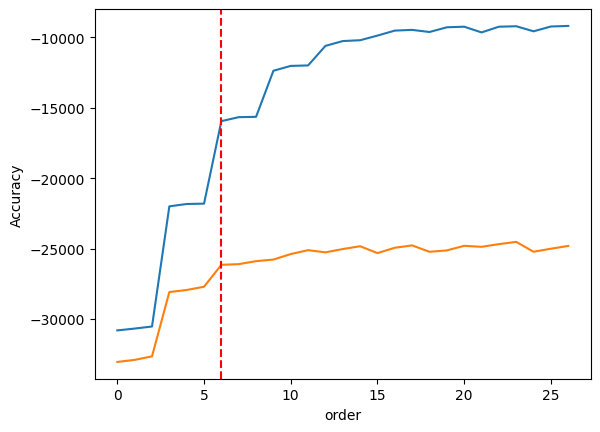

In [8]:
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=6,linestyle='--', color='r')
plt.show()

In [9]:
ans['params'][6]

{'max_depth': 7, 'n_estimators': 30}

In [10]:
rf.set_params(max_depth=7, n_estimators=30)
rf.fit(transformed_df, Ames.SalePrice)

,n_estimators,30
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


OverallQual           0.445815
TotalSF               0.393307
HouseAge              0.024924
HouseAgeSinceRemod    0.009693
TotalBaths            0.008137
LotArea               0.006954
KitchenQual           0.006942
GrLivArea             0.006011
1stFlrSF              0.005515
BsmtQual              0.005117
dtype: float64

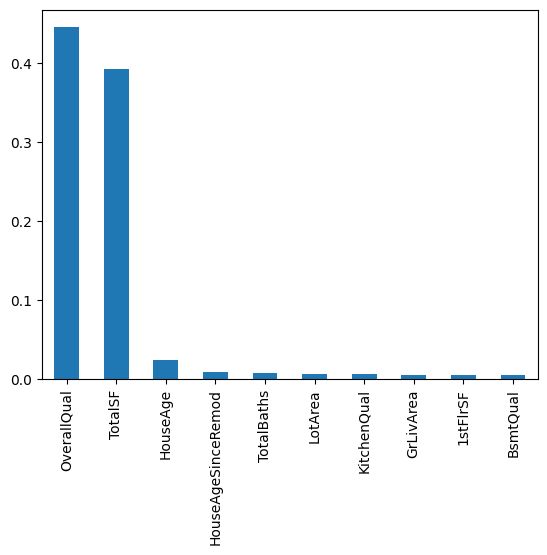

In [11]:
model_importance = pd.Series(rf.feature_importances_, index=transformed_df.columns).sort_values(ascending=False)

display(model_importance.head(10))
model_importance.head(10).plot(kind="bar")
plt.show()

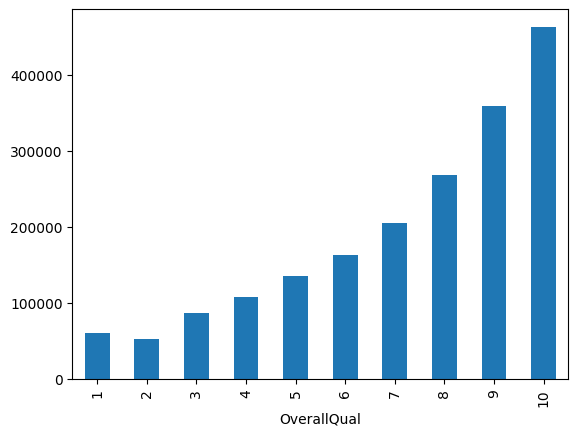

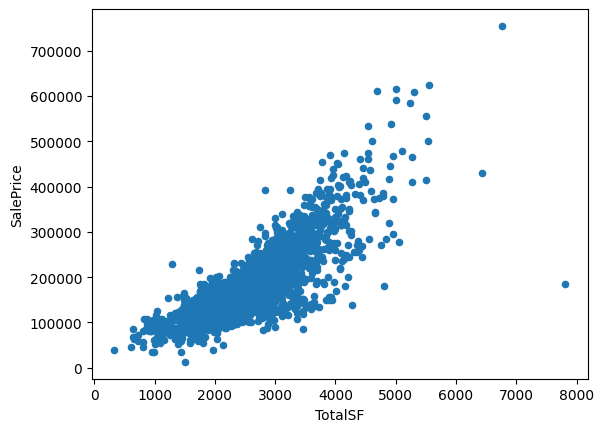

In [12]:
Ames.groupby(model_importance.index[0])['SalePrice'].mean().plot(kind="bar")

pd.concat([X_fe, target], axis = 1)[[model_importance.index[1], 'SalePrice']].plot(
    kind='scatter', x=model_importance.index[1], y='SalePrice')

plt.show()

In [18]:
transformed_df

,Electrical,LotArea,LotFrontage,MasVnrArea,cap:TotalBsmtSF,cap:BsmtFinSF1,cap:BsmtFinSF2,cap:BsmtUnfSF,1stFlrSF,2ndFlrSF,...,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,WasRemodeled_False,WasRemodeled_True
0,4.0,7890.0,68.245637,0.0,856.0,238.0,0.0,618.0,856.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4.0,4235.0,42.000000,149.0,1049.0,552.0,393.0,104.0,1049.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,4.0,6060.0,60.000000,0.0,837.0,737.0,0.0,100.0,1001.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,8146.0,80.000000,0.0,405.0,0.0,0.0,405.0,717.0,322.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4.0,8400.0,70.000000,0.0,810.0,643.0,0.0,167.0,810.0,855.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2.0,8854.0,68.245637,0.0,952.0,0.0,0.0,952.0,952.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2576,3.0,13680.0,68.245637,0.0,0.0,0.0,0.0,0.0,1733.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2577,3.0,6270.0,82.000000,0.0,1001.0,284.0,0.0,717.0,1001.0,1001.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2578,4.0,8826.0,68.245637,144.0,985.0,841.0,0.0,144.0,985.0,857.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [2]:
from sklearn.preprocessing import StandardScaler

X = transformed_df.copy()

# -- 0) (optional) peek for unexpected prefixes to help debug
maybe_prefixed = [c for c in X.columns if ":" in c]
if maybe_prefixed:
    print("Note: Some columns have tags (only when collisions occurred):", maybe_prefixed[:10], "...")

# -- 1) Curate & intersect with actual columns
SCALE_FEATURES_WANTED = [
    # Continuous
    "GrLivArea","LotFrontage","LotArea","MasVnrArea",
    "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
    "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
    "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
    "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
    # Counts
    "BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
    "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd",
    "Fireplaces","GarageCars","TotalBaths",
    # Ordinal-as-numeric
    "OverallQual","OverallCond",
    # Year/ages
    "HouseAge","HouseAgeSinceRemod","GarageAge"
]

LOG_COLS_WANTED = [
    "LotArea","LotFrontage","MasVnrArea",
    "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
    "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
    "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
    "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"
]

SCALE_FEATURES = [c for c in SCALE_FEATURES_WANTED if c in X.columns]
LOG_COLS       = [c for c in LOG_COLS_WANTED       if c in SCALE_FEATURES]

missing = sorted(set(SCALE_FEATURES_WANTED) - set(SCALE_FEATURES))
if missing:
    print("Skipping missing features (not in transformed_df):", missing)

# -- 2) Scale numerics (log on selected cols first)
X_num = X[SCALE_FEATURES].copy()
if LOG_COLS:
    X_num[LOG_COLS] = X_num[LOG_COLS].apply(np.log1p)

scaler = StandardScaler()
X_scaled_num = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=SCALE_FEATURES,
    index=X.index
)

# -- 3) Reattach the rest (one-hots + any non-scaled columns)
onehot_cols = [c for c in X.columns if c not in SCALE_FEATURES]
X_final = pd.concat([X_scaled_num, X[onehot_cols]], axis=1)

target_scaled = np.log1p(Ames["SalePrice"])

save_parquet(X_final, "../data/interim/X_final.parquet")

Note: Some columns have tags (only when collisions occurred): ['cap:TotalBsmtSF', 'cap:BsmtFinSF1', 'cap:BsmtFinSF2', 'cap:BsmtUnfSF', 'cap:GarageArea', 'Unnamed: 0', 'num_zero:TotalBsmtSF', 'num_zero:BsmtFinSF1', 'num_zero:BsmtFinSF2', 'num_zero:BsmtUnfSF'] ...
Skipping missing features (not in transformed_df): ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']


In [5]:
X_final

,GrLivArea,LotFrontage,LotArea,MasVnrArea,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,...,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,WasRemodeled_False,WasRemodeled_True
0,-1.588620,0.141937,-0.217772,-0.795661,-0.764551,-0.870843,-0.113739,-0.953233,-1.066314,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.942580,-1.359700,-1.471320,1.127538,-0.115687,-0.870843,-0.113739,-0.953233,1.105686,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-1.091416,-0.257649,-0.749430,-0.795661,-0.265173,-0.870843,-0.113739,0.989840,-1.066314,1.693304,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.973019,0.636082,-0.153439,-0.795661,-1.329908,0.893107,-0.113739,-0.953233,-1.066314,2.466196,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.525779,0.220791,-0.091576,-0.795661,-0.940801,1.190664,-0.113739,-0.953233,0.716879,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,-1.250895,0.141937,0.014477,-0.795661,-0.425349,-0.870843,-0.113739,-0.953233,1.073867,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2576,0.653027,0.141937,0.891061,-0.795661,1.486894,-0.870843,-0.113739,-0.953233,-1.066314,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2577,1.111743,0.712955,-0.680796,-0.795661,-0.265173,1.238744,-0.113739,-0.953233,-1.066314,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2578,0.846939,0.141937,0.008096,1.114526,-0.316598,1.191376,-0.113739,1.076307,1.064361,-0.430612,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
